# PROYECTO ALTERNAS
determinacion de valores climaticos , precipitacion humedad , con datos de estaciones climaticas del IDEAM teniendo en cuenta los años desde 1980 hasta 2024

Actividaes
1. Clasificacion de las estaciones en el area del proyecto, se relaiza un filtro para determinar solo las estaciones que estan cerca del area de la cuenca. son pintadas de color verde.
2. identificacion de los valores de los archivos .data
3. extraccion de informacion.
4. Clasificacion de infromacion por peridod de 1980 al 2024
5. organiacion del archivo de salida de precipitacion diaria por estaciones por año.

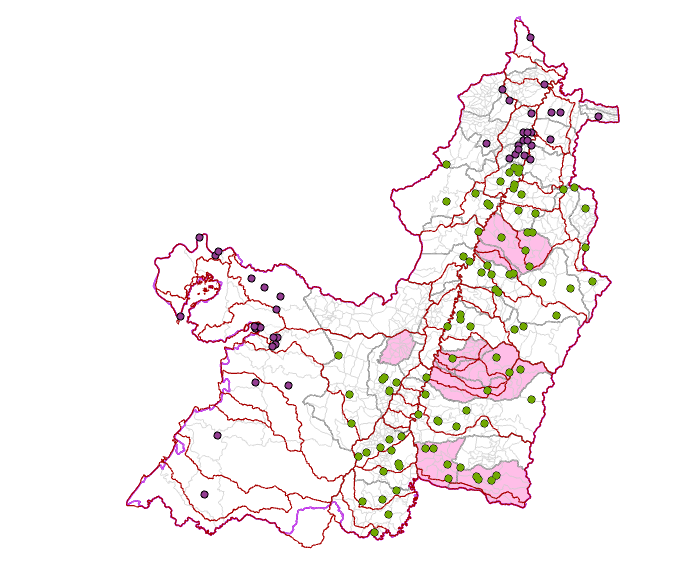



## 1. Creacion de carpeta con los datos de aceurdo alas estaciones del proyecto

In [ ]:
import os
import shutil
import pandas as pd

# Definir las rutas
ruta_data = r"D:\IDEAM\PrecipitacionNacionalDiaria"
ruta_excel = r"D:\IDEAM\ALTERNAS\Estaciones_IDEAM.xlsx"
ruta_destino = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas"

# Crear la carpeta de destino si no existe
if not os.path.exists(ruta_destino):
    os.makedirs(ruta_destino)

# Cargar el archivo de Excel con los códigos de las estaciones
df_estaciones = pd.read_excel(ruta_excel)

# Suponiendo que el código de la estación está en una columna llamada 'CODIGO'
codigos_estaciones = df_estaciones['CODIGO'].astype(str).tolist()

# Crear una lista para almacenar los archivos encontrados
archivos_encontrados = []

# Recorrer los archivos en la carpeta de precipitaciones
for archivo in os.listdir(ruta_data):
    if archivo.endswith(".data"):
        # Extraer el código de estación del nombre del archivo
        etiqueta, codigo_estacion_archivo = archivo.split('@')
        codigo_estacion_archivo = codigo_estacion_archivo.replace('.data', '')

        # Verificar si el código de la estación está en la lista de estaciones del Excel
        if codigo_estacion_archivo in codigos_estaciones:
            archivos_encontrados.append(archivo)

            # Copiar el archivo a la carpeta de destino
            ruta_origen = os.path.join(ruta_data, archivo)
            ruta_copia = os.path.join(ruta_destino, archivo)
            shutil.copy(ruta_origen, ruta_copia)

# Mostrar los archivos copiados
print(f"Archivos copiados: {archivos_encontrados}")


## 2.Creacion de Archivo de datos de acuerdo con etiqueta codigo valor y fecha


In [1]:
import os
import pandas as pd

# Definir las rutas locales
ruta_estaciones_alternas = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas"
ruta_salida_excel = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas_Consolidado.xlsx"

# Lista para almacenar la información consolidada
data_consolidada = []

# Recorrer los archivos en la carpeta de estaciones alternas
for archivo in os.listdir(ruta_estaciones_alternas):
    if archivo.endswith(".data"):
        # Extraer la etiqueta y el código del nombre del archivo
        etiqueta, codigo = archivo.split('@')
        codigo = codigo.replace('.data', '')

        # Leer el archivo .data para extraer la información
        with open(os.path.join(ruta_estaciones_alternas, archivo), 'r') as file:
            contenido = file.readlines()[1:]  # Saltar la primera línea que es el encabezado

        # Recorrer las filas del archivo y extraer fecha y valor
        for linea in contenido:
            fecha, valor = linea.strip().split('|')
            # Convertir el valor a tipo numérico
            valor = float(valor)
            data_consolidada.append([fecha, valor, etiqueta, codigo])

# Crear un DataFrame con la información consolidada
df_resultado = pd.DataFrame(data_consolidada, columns=['FECHA', 'VALOR', 'ETIQUETA', 'CODIGO'])

# Asegurar que 'VALOR' es de tipo numérico
df_resultado['VALOR'] = pd.to_numeric(df_resultado['VALOR'])

# Guardar el DataFrame en un archivo Excel en la ruta de salida
df_resultado.to_excel(ruta_salida_excel, index=False)

print(f"Archivo Excel generado en: {ruta_salida_excel}")


Archivo Excel generado en: D:\IDEAM\ALTERNAS\Estaciones_Alternas_Consolidado.xlsx


## 2. Ingresar datos al archivo
se toma el archivo generado y se le carga la informacion relacionada a la estacion , municipio , nombre

In [4]:
import os
import pandas as pd

# Rutas de los archivos
ruta_estaciones_alternas = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas_Consolidado.xlsx"
ruta_excel_CNE = r"D:\IDEAM\ALTERNAS\CNE_IDEAM.xls"
ruta_salida = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas_Final.xlsx"

# Cargar los datos del consolidado de estaciones alternas
df_estaciones_alternas = pd.read_excel(ruta_estaciones_alternas)

# Cargar los datos del archivo CNE_IDEAM.xls
df_cne_ideam = pd.read_excel(ruta_excel_CNE)

# Unir los DataFrames usando la columna 'CODIGO' como llave y tomar 'nombre' y 'MUNICIPIO'
df_final = pd.merge(df_estaciones_alternas, df_cne_ideam[['CODIGO', 'nombre', 'MUNICIPIO']], on='CODIGO', how='left')

# Guardar el resultado en un nuevo archivo Excel
df_final.to_excel(ruta_salida, index=False)

print(f"Archivo Excel final generado en: {ruta_salida}")



Archivo Excel final generado en: D:\IDEAM\ALTERNAS\Estaciones_Alternas_Final.xlsx


## 3. oranizacion de la informacion
se utiliza un archivo modelo para organizacion de la informacion

In [5]:
import pandas as pd

# Ruta de los archivos a procesar
ruta_estaciones_alternas = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas_Final.xlsx"
ruta_salida_organizada = r"D:\IDEAM\ALTERNAS\Estaciones_Organizadas.xlsx"

# Cargar el archivo final generado previamente
df_final = pd.read_excel(ruta_estaciones_alternas)

# Convertir la columna de fechas a tipo datetime para extraer año y mes
df_final['FECHA'] = pd.to_datetime(df_final['FECHA'])

# Crear nuevas columnas de AÑO y MES
df_final['AÑO'] = df_final['FECHA'].dt.year
df_final['MES'] = df_final['FECHA'].dt.month
df_final['DIA'] = df_final['FECHA'].dt.day

# Pivotar la tabla para tener un formato similar al modelo
df_pivot = df_final.pivot_table(index=['CODIGO', 'MUNICIPIO', 'nombre', 'AÑO', 'MES'],
                                columns='DIA', values='VALOR', aggfunc='sum').reset_index()

# Calcular el promedio mensual (ignorar los días que no tienen datos)
df_pivot['Prom_mes'] = df_pivot.loc[:, 1:31].mean(axis=1)

# Guardar el resultado en un archivo Excel
df_pivot.to_excel(ruta_salida_organizada, index=False)

print(f"Archivo Excel organizado generado en: {ruta_salida_organizada}")


Archivo Excel organizado generado en: D:\IDEAM\ALTERNAS\Estaciones_Organizadas.xlsx


Se organiza la informacion por promedio año

In [7]:
import pandas as pd

# Ruta de los archivos a procesar
ruta_estaciones_alternas = r"D:\IDEAM\ALTERNAS\Estaciones_Alternas_Final.xlsx"
ruta_salida_promedios_mes = r"D:\IDEAM\ALTERNAS\Estaciones_Promedios_Mes.xlsx"

# Leer solo las columnas necesarias para optimizar el proceso
# Puedes ajustar estas columnas según tus necesidades
df_final = pd.read_excel(ruta_estaciones_alternas, usecols=['FECHA', 'VALOR', 'CODIGO', 'MUNICIPIO', 'nombre'])

# Convertir la columna de fechas a tipo datetime para extraer año y mes
df_final['FECHA'] = pd.to_datetime(df_final['FECHA'])

# Crear nuevas columnas de AÑO y MES
df_final['AÑO'] = df_final['FECHA'].dt.year
df_final['MES'] = df_final['FECHA'].dt.month

# Calcular el promedio mensual de precipitación
df_promedios = df_final.groupby(['CODIGO', 'MUNICIPIO', 'nombre', 'AÑO', 'MES'])['VALOR'].mean().reset_index()

# Pivotar la tabla para tener un formato similar al modelo con los meses como columnas
df_pivot = df_promedios.pivot_table(index=['CODIGO', 'MUNICIPIO', 'nombre', 'AÑO'],
                                    columns='MES', values='VALOR').reset_index()

# Renombrar las columnas para que coincidan con los nombres de los meses
df_pivot.columns = ['CODIGO', 'MUNICIPIO', 'nombre', 'AÑO', 'ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN',
                    'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

# Calcular el promedio anual de precipitación
df_pivot['Prom_año'] = df_pivot.loc[:, 'ENE':'DIC'].mean(axis=1)

# Guardar el resultado en un archivo Excel
df_pivot.to_excel(ruta_salida_promedios_mes, index=False)

print(f"Archivo Excel con promedios mensuales y anuales generado en: {ruta_salida_promedios_mes}")



Archivo Excel con promedios mensuales y anuales generado en: D:\IDEAM\ALTERNAS\Estaciones_Promedios_Mes.xlsx


verificaicon de cuantas estaciones tienen datos entre 1986 y 2024

In [10]:
import pandas as pd

# Ruta del archivo Estaciones_Promedios_Mes.xlsx
ruta_estaciones_promedios_mes = r"D:\IDEAM\ALTERNAS\Estaciones_Promedios_Mes.xlsx"

# Cargar el archivo Excel
df_estaciones_promedios = pd.read_excel(ruta_estaciones_promedios_mes)

# Filtrar las estaciones que tienen datos de precipitación entre 1986 y 2024
df_filtrado = df_estaciones_promedios[(df_estaciones_promedios['AÑO'] >= 1986) & (df_estaciones_promedios['AÑO'] <= 2024)]

# Obtener el número de estaciones únicas que cumplen con el criterio
estaciones_con_datos = df_filtrado['CODIGO'].nunique()

# Mostrar el número de estaciones
print(f"El número de estaciones con datos de precipitación entre 1986 y 2024 es: {estaciones_con_datos}")


El número de estaciones con datos de precipitación entre 1986 y 2024 es: 43


## generacion de archivo final

In [11]:
import pandas as pd

# Ruta del archivo Estaciones_Promedios_Mes.xlsx
ruta_estaciones_promedios_mes = r"D:\IDEAM\ALTERNAS\Estaciones_Promedios_Mes.xlsx"

# Ruta de salida para el nuevo archivo filtrado
ruta_salida_filtrada = r"D:\IDEAM\ALTERNAS\Estaciones_Promedios_Mes_1986_2024.xlsx"

# Cargar el archivo Excel
df_estaciones_promedios = pd.read_excel(ruta_estaciones_promedios_mes)

# Filtrar las estaciones que tienen datos de precipitación entre 1986 y 2024
df_filtrado = df_estaciones_promedios[(df_estaciones_promedios['AÑO'] >= 1986) & (df_estaciones_promedios['AÑO'] <= 2024)]

# Guardar el DataFrame filtrado en un nuevo archivo Excel
df_filtrado.to_excel(ruta_salida_filtrada, index=False)

print(f"Archivo filtrado generado en: {ruta_salida_filtrada}")


Archivo filtrado generado en: D:\IDEAM\ALTERNAS\Estaciones_Promedios_Mes_1986_2024.xlsx
